<a href="https://colab.research.google.com/github/yehslee/anxiety-prevalence/blob/main/Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade geopandas
!pip install --upgrade descartes
!pip install country_converter --upgrade
!pip install --upgrade scikit-learn
!pip install cython

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz 
from sklearn.tree import export_graphviz
from IPython.display import display
from sklearn import tree

%matplotlib inline

     |████████████████████████████████| 972kB 7.1MB/s 
     |████████████████████████████████| 14.8MB 293kB/s 
     |████████████████████████████████| 10.9MB 17.9MB/s 
Requirement already up-to-date: descartes in /usr/local/lib/python3.6/dist-packages (1.1.0)
     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for country-converter: filename=country_converter-0.7.1-cp36-none-any.whl size=50807 sha256=d04a24dd490cebb3c83128de048af7bc99c01d7db189bf9227f204d5db486fc0
  Stored in directory: /root/.cache/pip/wheels/75/be/cb/3c8d07bca8f2c0670e996a174fed372585b32d3aa03f40996a
Successfully built country-converter
     |████████████████████████████████| 6.8MB 8.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import requests

def save_file(url, file_name):
  r = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(r.content)
  
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/data.zip', 'data.zip')
save_file('https://courses.cs.washington.edu/courses/cse163/19sp/' +
          'files/lectures/05-13/gz_2010_us_040_00_5m.json', 
          'gz_2010_us_040_00_5m.json')
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/ne_110m_admin_0_countries.shx  
  inflating: data/ne_110m_admin_0_countries.shp  
 extracting: data/ne_110m_admin_0_countries.cpg  
 extracting: data/ne_110m_admin_0_countries.VERSION.txt  
  inflating: data/ne_110m_admin_0_countries.dbf  
  inflating: data/ne_110m_admin_0_countries.README.html  
  inflating: data/ne_110m_admin_0_countries.prj  


# Merge Anxiety and Geometry Data

In [ ]:
import country_converter as coco
def shorter_names(column):
  cc = coco.CountryConverter()
  column = column.map(lambda x:
                      cc.convert(names=x, to='name_short'))
  return column


In [ ]:
def merge_data(anxiety, countries):
  """
  Takes in the anxiety dataframe and the countries geopandas dataframe to incorporate plotting.
  It then merges the two datasets according to country name, and returns the merged geopandas dataframe.
  """
  geometry = countries[['NAME_EN', 'CONTINENT', 'geometry']]
  geometry['NAME_EN'] = shorter_names(geometry['NAME_EN'])
  anxiety['location'] = shorter_names(anxiety['location'])
  merged = geometry.merge(anxiety, left_on='NAME_EN', right_on='location', how='left')
  return merged


# Question 1


How has the prevalence of anxiety changed from 2000 to 2017 for each continent, country, and gender?

pandas.core.frame.DataFrame

In [ ]:
def country_prev_year(data):
  """
  Takes in merged data set and compares the prevalence of anxiety in each country
  in the years 2000, 2008, and 2017. 
  It produces three geospatial plots for the three years, and saves the figure as 
  'country_prev_year.png'.  
  """
  filtered = data[['NAME_EN', 'year', 'val', 'geometry']]
  # by country for the year 2000
  year_2000 = filtered[filtered['year'] == 2000]
  country_2000 = year_2000.dissolve(by='NAME_EN', aggfunc='mean')

  # by country for the year 2008
  year_2008 = filtered[filtered['year'] == 2008]
  country_2008 = year_2008.dissolve(by='NAME_EN', aggfunc='mean')

  # by country for the year 2017
  year_2017 = filtered[filtered['year'] == 2017]
  country_2017 = year_2017.dissolve(by='NAME_EN', aggfunc='mean')

  # plots the geospatial data on the same figure 
  fig, [ax1, ax2, ax3] = plt.subplots(3, figsize=(15, 10))
  country_2000.plot(column='val', ax=ax1, legend=True)
  country_2008.plot(column='val', ax=ax2, legend=True)
  country_2017.plot(column='val', ax=ax3, legend=True)

  ax1.set_title('Anxiety Prevalence in Each Country (2000)')
  ax2.set_title('Anxiety Prevalence in Each Country (2008)')
  ax3.set_title('Anxiety Prevalence in Each Country (2017)')
  plt.subplots_adjust(hspace=0.5)

  # save figure as png file
  plt.savefig('country_prev_year.png')

In [ ]:
def prev_per_gender(data):
  """
  Takes in a merged data set and looks at the prevalence of anxiety for each
  gender (male, female, and both) over the years of 2000-2017.
  Creates a line graph and saves the figure as 'gender_prev.png'
  """
  # per year group by gender
  female_merged = data[data['sex'] == 'Female']
  female_prev = female_merged.groupby('year')['val'].mean()
  female_prev = female_prev.reset_index()
  female_prev['year'] = female_prev['year'].astype(str)

  male_merged = data[data['sex'] == 'Male']
  male_prev = male_merged.groupby('year')['val'].mean()
  male_prev = male_prev.reset_index()
  male_prev['year'] = male_prev['year'].astype(str)

  both_prev = data.groupby('year')['val'].mean()
  both_prev = both_prev.reset_index()
  both_prev['year'] = both_prev['year'].astype(str)

  fig, [ax1, ax2] = plt.subplots(2, figsize=(10, 10))
  sns.lineplot(ax=ax1, x='year', y='val', data=female_prev, color='orange', label='Female')
  sns.lineplot(ax=ax1, x='year', y='val', data=male_prev, color='green', label='Male')
  sns.lineplot(ax=ax2, x='year', y='val', data=both_prev, label="Both Sexes")

  plt.subplots_adjust(hspace=0.5)
  ax1.set_title('Prevalence of Anxiety in Males and Females (2000 - 2017)')
  ax2.set_title('Prevalence of Anxiety in Both Sexes (2000 - 2017)')
  ax1.set_xticklabels(labels=both_prev['year'],rotation=-45)
  ax2.set_xticklabels(labels=both_prev['year'],rotation=-45)

  # save plot as png file
  plt.savefig('gender_prev.png')

# Question 2

For both continental and gender groups, are there specific ages when people begin or stop feeling anxiety?


In [ ]:
def continents_by_gender_group(data):
  '''
  This function creates three graphs that support side-by-side analysis of
  how gender groups affect the prevalence of anxiety based on the continent
  one is from and what age group they belong to.
  '''
  # filters dataset for relevant columns
  continent_data = data[['location', 'year', 'CONTINENT', 'sex', 'age', 'val']]
  # groups dataset by unique combinations of continent and age and sums the
  # prevalence of anxiety for each of the combinations (both genders)
  by_continent = continent_data.groupby(['CONTINENT', 'age'], sort=False)['val'].sum()
  # reset_index creates a dataframe from the resulting grouped-by series
  by_continent = by_continent.reset_index()
  # filters continent_data for male data
  male_continent_data = continent_data[continent_data['sex'] == 'Male']
  # groups dataset by unique combinations of continent and age and sums the
  # prevalence of anxiety for those male groups
  male_continent_data = male_continent_data.groupby(['CONTINENT', 'age'], sort=False)['val'].sum()
  # reset_index creates a dataframe from the resulting grouped-by series
  male_continent_data = male_continent_data.reset_index()
  # filters continent_data for female data
  female_continent_data = continent_data[continent_data['sex'] == 'Female']
  # groups dataset by unique combinations of continent and age and sums the
  # prevalence of anxiety for those female groups
  female_continent_data = female_continent_data.groupby(['CONTINENT', 'age'], sort=False)['val'].sum()
  # reset_index creates a dataframe from the resulting grouped-by series
  female_continent_data = female_continent_data.reset_index()
  # creates a figure to plot three graphs side-by-side
  fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(22, 8))
  # plots first graph of data of both genders with anxiety
  both_genders_by_continent = sns.lineplot(data=by_continent, sort=False, x='age', y='val', hue='CONTINENT', legend='full', ax=ax1)
  # plots second graph of data of males with anxiety
  male_by_continent = sns.lineplot(data=male_continent_data, sort=False, x='age', y='val', hue='CONTINENT', legend='full', ax=ax2)
  # plots third graph of data of females with anxiety
  female_by_continent = sns.lineplot(data=female_continent_data, sort=False, x='age', y='val', hue='CONTINENT', legend='full', ax=ax3)
  # list of all the age groups in the x-axis
  age_order = ["1 to 4", "5 to 9", "10 to 14", "15 to 19", "20 to 24", "25 to 29",
                "30 to 34", "35 to 39", "40 to 44", "45 to 49", "50 to 54",
                "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79",
                "80 to 84", "85 to 89", "90 to 94"]
  # list of all the plots in the figure
  continent_plots = [both_genders_by_continent, male_by_continent, female_by_continent]
  # for loop to set various features for each of the graphs
  for i in continent_plots:
    i.set(ylim=(0, 300000000))  # y-axis bounds
    i.set_xlabel('Age Group')  # x-axis label
    i.set_ylabel('Number of People (Hundred Million)')  # y-axis label
    # rotates tick labels for better visibility
    i.set_xticklabels(labels=age_order, rotation=-45)
  # title for first graph
  ax1.set_title('Anxiety Per Continent by Age Group (Both Genders)')
  # title for second graph
  ax2.set_title('Anxiety Per Continent by Age Group (Male)')
  # title for third graph
  ax3.set_title('Anxiety Per Continent by Age Group (Female)')
  # saves figure in png file
  plt.savefig('anxiety_continents_gender.png')

In [ ]:
def continents_by_age_group(data):
  '''
  This function allows for analyses of prevalence of anxiety in each age group
  based on individual continents. This function is an extention of the
  continents_by_gender_group function, but instead of graphing the genders as
  different plots, it groups the data by continent and illustrates the difference
  in prevalence of anxiety per age group based on what continent one is from.
  '''
  # filters dataset for relevant columns
  continent_data = merged[['location', 'year', 'CONTINENT', 'sex', 'age', 'val']]
  # groups dataset by unique combinations of continent, year, and age and
  # sums the prevalence of anxiety for each of the combinations
  by_continents = continent_data.groupby(['CONTINENT', 'year', 'age'], sort=False)['val'].sum()
  # reset_index creates a dataframe from the grouped-by series
  by_continents = by_continents.reset_index()
  # creates a figure with six graphs for each of the continents
  fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, ncols=3, figsize=(28, 14))
  # filters dataset for data pertaining to Asia
  asia = by_continents[by_continents['CONTINENT'] == 'Asia']
  # creates a color palette for the Asia plot, matching the figure above
  blue = sns.light_palette("blue", as_cmap=True)
  # plots first graph of anxiety by age groups in Asia
  asia_plot = sns.lineplot(data=asia, sort=False, x='age', y='val', hue='year', ax=ax1, palette=blue)
  # title for first graph
  asia_plot.set_title('Asia\'s Anxiety Per Age Group Per Year')
  # filters dataset for data pertaining to Europe
  europe = by_continents[by_continents['CONTINENT'] == 'Europe']
  # creates a color palette for the Europe plot, matching the figure above
  orange = sns.light_palette("orange", as_cmap=True)
  # plots first graph of anxiety by age groups in Europe
  europe_plot = sns.lineplot(data=europe, sort=False, x='age', y='val', hue='year', ax=ax2, palette=orange)
  # title for second graph
  europe_plot.set_title('Europe\'s Anxiety Per Age Group Per Year')
  # filters dataset for data pertaining to North America
  north_america = by_continents[by_continents['CONTINENT'] == 'North America']
  # creates a color palette for the North America plot, matching the figure above
  green = sns.light_palette("green", as_cmap=True)
  # plots first graph of anxiety by age groups in North America
  north_america_plot = sns.lineplot(data=asia, sort=False, x='age', y='val', hue='year', ax=ax3, palette=green)
  # title for third graph
  north_america_plot.set_title('North America\'s Anxiety Per Age Group Per Year')
  # filters dataset for data pertaining to South America
  south_america = by_continents[by_continents['CONTINENT'] == 'South America']
  # creates a color palette for the South America plot, matching the figure above
  red = sns.light_palette("red", as_cmap=True)
  # plots first graph of anxiety by age groups in South America
  south_america_plot = sns.lineplot(data=south_america, sort=False, x='age', y='val', hue='year', ax=ax4, palette=red)
  # title for fourth graph
  south_america_plot.set_title('South America\'s Anxiety Per Age Group Per Year')
  # filters dataset for data pertaining to Africa
  africa = by_continents[by_continents['CONTINENT'] == 'Africa']
  # creates a color palette for the Africa plot, matching the figure above
  purple = sns.light_palette("purple", as_cmap=True)
  # plots first graph of anxiety by age groups in Africa
  africa_plot = sns.lineplot(data=africa, sort=False, x='age', y='val', hue='year', ax=ax5, palette=purple)
  # title for fifth graph
  africa_plot.set_title('Africa\'s Anxiety Per Age Group Per Year')
  # filters dataset for data pertaining to Oceania
  oceania = by_continents[by_continents['CONTINENT'] == 'Oceania']
  # creates a color palette for the Oceania plot, matching the figure above
  brown = sns.light_palette("brown", as_cmap=True)
  # plots first graph of anxiety by age groups in Oceania
  oceania_plot = sns.lineplot(data=oceania, sort=False, x='age', y='val', hue='year', ax=ax6, palette=brown)
  # title for sixth graph
  oceania_plot.set_title('Oceania\'s Anxiety Per Age Group Per Year')
  # list of all plots in the figure
  plots = [asia_plot, europe_plot, north_america_plot, south_america_plot, africa_plot]
  # list of all the age groups in the x-axis
  age_order = ["1 to 4", "5 to 9", "10 to 14", "15 to 19", "20 to 24", "25 to 29",
                "30 to 34", "35 to 39", "40 to 44", "45 to 49", "50 to 54",
                "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79",
                "80 to 84", "85 to 89", "90 to 94"]
  # unique bounds for Oceania plot because the data is a lot less
  oceania_plot.set(ylim=(0, 1000000))
  # sets x-axis tick marks for visibility
  oceania_plot.set_xticklabels(labels=age_order, rotation=-45)
  # for loop to set various features for each of the graphs
  for i in plots:
    i.set(ylim=(0, 20000000))  # sets y-axis bounds
    i.set_xticklabels(labels=age_order, rotation=-45)  # sets x-axis tick marks
  # saves figure in png file
  plt.savefig('anxiety_continents_year.png')

In [ ]:
def anxiety_in_us(data):
  '''
  This function focuses particularly on the data from the United States and
  plots how each age group has been affected by anxiety throughout 2000 and
  2017. This function is useful for understanding patterns in anxiety in
  other countries as well, because it allows us to look at the numbers
  associated with the country directly.
  '''
  # filters dataset for data pertaining to the United States
  usa = data[(data['location'] == 'United States')]
  # creates a figure to plot the graph
  fig, ax = plt.subplots(figsize=(10, 7))
  # groups the data by year and age and sums the prevalance of anxiety of
  # those specific groups
  usa_total = usa.groupby(['year', 'age'], sort=False)['val'].sum()
  # reset_index changes the series into dataframe
  usa_total = usa_total.reset_index()
  # plots a graph of anxiety in the United States by age group and year
  usa_total = sns.lineplot(data=usa_total, x='age',y='val', hue='year', legend='full', sort=False, ax=ax)
  # list of all the age groups in the x-axis
  age_order = ["1 to 4", "5 to 9", "10 to 14", "15 to 19", "20 to 24", "25 to 29",
                  "30 to 34", "35 to 39", "40 to 44", "45 to 49", "50 to 54",
                  "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79",
                  "80 to 84", "85 to 89", "90 to 94"]
  # sets the y-axis bounds
  usa_total.set(ylim=(0, 2500000))
  # rotates x-axis tick labels for visibility
  usa_total.set_xticklabels(labels=age_order, rotation=-45)
  # sets title for the graph
  ax.set_title("Prevalence of Anxiety Per Age Group in United States")
  # sets x-axis label on graph
  usa_total.set_xlabel('Age Groups')
  # sets y-axis label on graph
  usa_total.set_ylabel('Proportion of Survey Takers by Year')
  # saves figure in png file
  plt.savefig('anxiety_in_us.png')

In [ ]:
def anxiety_in_us_by_gender(data):
  '''
  This function takes a closer look at data from the United States and
  depicts trends in anxiety based on gender and age group. Using the
  given prevalence, it calculates the proportion of the population that
  has anxiety and shows how many people per age group make up that population.
  '''
  # filters dataset for data pertaining to the United States
  usa = data[(data['location'] == 'United States')]
  years = usa['year'].unique() # array of all the unique years in dataset
  # creates an empty dictionary for total populations per year
  total_pop_per_year = dict()
  # iterates through array of years
  for i in years:
    # filters through dataset for data pertaining to that year
    data = usa[usa['year'] == i]
    # sums the value column of the data of that year
    total_pop = data['val'].sum()
    # assigns total population to the key-value pair in the dictionary
    total_pop_per_year[i] = total_pop
  # creates new column in dataset and replicates with the year of that row
  usa['proportion'] = usa['year']
  # replaces year with total population based on the year in the 
  # 'proportion column'
  usa = usa.replace({'proportion': total_pop_per_year})
  # divides each value in proportion with the prevalence of anxiety with
  # the total population
  usa['proportion'] = usa['val'] / usa['proportion']
  # filters dataset for male data
  usa_male = usa[usa['sex'] == 'Male']
  # filters dataset for female data
  usa_female = usa[usa['sex'] == 'Female']
  # creates a figure to plot four graphs
  fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, ncols=2, figsize=(30, 15))
  # plots graph of anxiety in US by age group and year, male only
  male = sns.lineplot(data=usa_male, x='age',y='val', hue='year', legend='full', sort=False, ax=ax1)
  # sets y-axis bounds for first graph
  male.set(ylim=(0, 2000000))
  male.set_ylabel('Number of People')  # sets y-axis label for first graph
  # title for first graph
  ax1.set_title("Prevalence of Anxiety Per Age Group in United States (Male)")
  # plots graph of anxiety in US by age group and year, female only
  female = sns.lineplot(data=usa_female, x='age',y='val', hue='year', legend='full', sort=False, ax=ax2)
  # sets y-axis bounds for second graph
  female.set(ylim=(0, 2000000))
  female.set_ylabel('Number of People')  # sets y-axis label for second graph
  # title for second graph
  ax2.set_title("Prevalence of Anxiety Per Age Group in United States (Female)")
  # plots graph of proportion of anxiety in US by age group and year, male only
  male_proport = sns.lineplot(data=usa_male, x='age',y='proportion', hue='year', legend='full', sort=False, ax=ax3)
  # sets y-axis bounds for third graph
  male_proport.set(ylim=(0, 0.1))
  # sets y-axis label for third graph
  male_proport.set_ylabel('Proportion of Total People')
  # title for third graph
  ax3.set_title("Proportion of Anxiety Per Age Group in United States (Male)")
  # plots graph of proportion of anxiety in US by age group and year, female only
  female_proport = sns.lineplot(data=usa_female, x='age',y='proportion', hue='year', legend='full', sort=False, ax=ax4)
  # sets y-axis bounds for fourth graph
  female_proport.set(ylim=(0, 0.1))
  # sets y-axis label for fourth graph
  female_proport.set_ylabel('Proportion of Total People')
  # title for fourth graph
  ax4.set_title("Proportion of Anxiety Per Age Group in United States (Female)")
  # list of all graphs in figure
  plots = [male, female, male_proport, female_proport]
  # list of all the age groups in the x-axis
  age_order = ["1 to 4", "5 to 9", "10 to 14", "15 to 19", "20 to 24", "25 to 29",
                  "30 to 34", "35 to 39", "40 to 44", "45 to 49", "50 to 54",
                  "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79",
                  "80 to 84", "85 to 89", "90 to 94"]
  # for loop to set various features for each of the graphs
  for i in plots:
    i.set_xticklabels(labels=age_order, rotation=-45)  # sets x-axis tick marks
    i.set_xlabel('Age Groups')  # sets x-axis label
  # saves figure in png file
  plt.savefig('anxiety_in_us_gender.png')

# Question 3

What does the future of anxiety prevalence look like in the US?

In [ ]:
def future_anxiety_prevelance(anxiety):
  """
  This function takes in the anxiety dataset, and runs the 
  methods that train and test a machhine learning model
  in order to predict anxiety prevelence on unseen data
  """
  # Generate USA only data set
  usa = anxiety[anxiety['location'] == 'United States']
  usa = usa[['year', 'age', 'val', 'sex']]

  # Data set using all features
  usa_all = usa.groupby(['year', 'age', 'sex'])['val'].sum()
  usa_all = usa_all.reset_index() 
  usa_all['year'] = usa_all['year'].astype('int')
  # Data to create model
  usa_all_train = usa_all[usa_all['year'] < 2015]
  # Unseen future data 
  test_data_all = usa_all[usa_all['year'] >= 2015]

  # Data set with no age range feature
  usa_no_age = usa[['year', 'val', 'sex']]
  usa_no_age = usa_no_age.groupby(['year', 'sex'])['val'].sum()
  usa_no_age = usa_no_age.reset_index()
  usa_no_age['year'] = usa_no_age['year'].astype('int')
  usa_no_age_train = usa_no_age[usa_no_age['year'] < 2015]
  test_data_no_age = usa_no_age[usa_no_age['year'] >= 2015]

  # Determine hyperparameters for data with all features
  X_all = usa_all_train.loc[:, usa_all_train.columns != 'val']
  X_all = pd.get_dummies(X_all)
  y_all = usa_all_train['val']
  max_val_tests(X_all, y_all)

  # Fit model based on hyperparameters determined by testing
  ml = my_model(usa_all_train, 15, 30)

  # Test model on new data
  X_new_data = test_data_all.loc[:, test_data_all.columns != 'val']
  X_new_data = pd.get_dummies(X_new_data)
  y_new_data = test_data_all['val']
  prediction = ml.predict(X_new_data)
  mse = mean_squared_error(y_new_data, prediction)
  print(mse)

  # Determine hyperparameters for data with no age feature
  X_no_age = usa_no_age.loc[:, usa_no_age.columns != 'val']
  X_no_age = pd.get_dummies(X_no_age)
  y_no_age = usa_no_age['val']
  max_val_tests(X_no_age, y_no_age)

  # Fit model based on hyperparameters
  ml_2 = my_model(usa_no_age_train, 5, 10)

  # Test model on new data
  X_new_data_age = test_data_no_age.loc[:, test_data_no_age.columns != 'val']
  X_new_data_age = pd.get_dummies(X_new_data_age)
  y_new_data_age = test_data_no_age['val']
  prediction_age = ml_2.predict(X_new_data_age)

  # Look at actual vs predicted values
  y_new_data_age = y_new_data_age.tolist()
  for i in range(len(y_new_data_age)):
    print('Actual:    ', y_new_data_age[i])
    print('Predicted: ', prediction_age[i])
    print('Difference:', (y_new_data_age[i] - prediction_age[i]))
    print('% Error:   ', abs(prediction_age[i]-y_new_data_age[i]) / y_new_data_age[i] * 100)
    print()

In [ ]:
def my_model(my_data, depth, nodes):
  """
  This function takes in a dataframe, and ints for max dept
  and max possible leaf nodes for hyperparameters of a 
  scikit learn regression model, fits a model to the data,
  and displays and returns its decision tree. 
  """
  # fit model
  X_my_model = my_data.loc[:, my_data.columns != 'val']
  X_my_model = pd.get_dummies(X_my_model)
  y_my_model = my_data['val']
  model = DecisionTreeRegressor(max_depth=depth, max_leaf_nodes=nodes, random_state=1)
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  #model = model.fit(X_train, y_train)
  model = model.fit(X_my_model, y_my_model)

  # Graph decision tree
  dot_data = export_graphviz(model, out_file=None, 
                     feature_names=X_my_model.columns, filled=True,
                     rounded=True, special_characters=True)  
  graph = graphviz.Source(dot_data)
  display(graph)

  return model

In [ ]:
def max_val_tests(X_tuning, y_tuning):
  """
  This function takes features (X_tuning) and labels (y_tuning)
  for parameters as dataframes, and tests a range of max depth
  and max leaf node values for a regression model, plotting the results
  in terms of mean squared error. 
  """

  # Generate mean squared error values for the hhyperprameters
  X_train, X_test, y_train, y_test = train_test_split(X_tuning, y_tuning, test_size=0.2, random_state=1)                             
  data = []
  for i in range(2, 50):
    model_1 = DecisionTreeRegressor(max_depth=i, random_state=1)
    model_2 = DecisionTreeRegressor(max_leaf_nodes=i, random_state=1)
    model_1.fit(X_train, y_train)
    model_2.fit(X_train, y_train)
    
    y_train_pred_1 = model_1.predict(X_train)
    y_train_pred_2 = model_2.predict(X_train)
    mse_train_1 = mean_squared_error(y_train, y_train_pred_1)
    mse_train_2 = mean_squared_error(y_train, y_train_pred_2)
    
    y_test_pred_1 = model_1.predict(X_test)
    y_test_pred_2 = model_2.predict(X_test)
    mse_test_1= mean_squared_error(y_test, y_test_pred_1)
    mse_test_2= mean_squared_error(y_test, y_test_pred_2)
    
    # compile results in dictionary
    data.append({'max depth': i, 'max leaf nodes': i, 'mse_train_1': mse_train_1, 
                'mse_test_1': mse_test_1, 'mse_train_2': mse_train_2,
                'mse_test_2': mse_test_2})
    

  data = pd.DataFrame(data)

  # Make figure for plotting results with four axis
  fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, ncols=2, figsize=(10, 10))

  # ax1
  sns.lineplot(data=data, x='max depth', y='mse_train_1', legend='full', ax=ax1, )
  ax1.set(ylabel='Mean Squared Error')
  ax1.set(xlim=(0, 20))
  ax1.set(ylim=(0, None))

  #ax2
  sns.lineplot(data=data, x='max depth', y='mse_test_1', legend='full', ax=ax2)
  ax2.set(ylabel='Mean Squared Error')
  ax2.set(xlim=(0, 20))
  ax2.set(ylim=(0, None))

  #ax3
  sns.lineplot(data=data, x='max leaf nodes', y='mse_train_2', ax=ax3)
  ax3.set(ylabel='Mean Squared Error')
  ax3.set(xlim=(0, 40))
  ax3.set(ylim=(0, None))

  #ax4
  sns.lineplot(data=data, x='max leaf nodes', y='mse_test_2', ax=ax4)
  ax4.set(ylabel='Mean Squared Error')
  ax4.set(xlim=(0, 40))
  ax4.set(ylim=(0, None))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


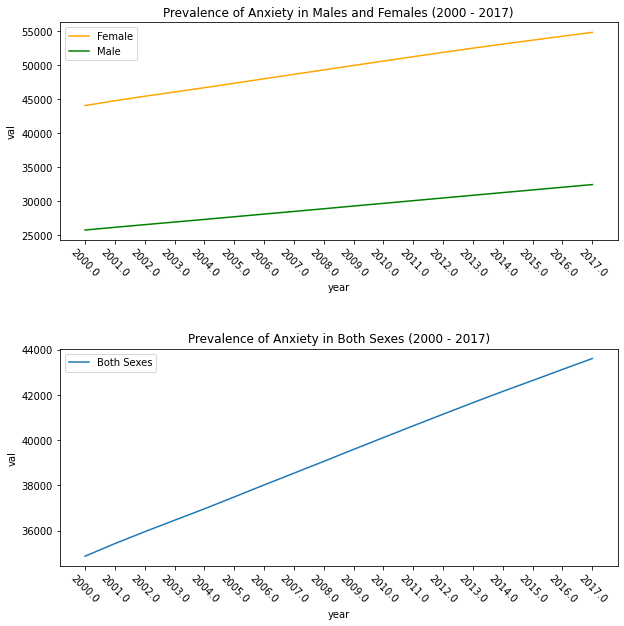

In [ ]:
def main():
  # read datasets for anxiety and countries 
  url = 'https://raw.githubusercontent.com/yennilee2/cse163/master/IHME-GBD_2017_DATA-1891f182-1.csv'
  anxiety = pd.read_csv(url)
  url_2 = 'https://raw.githubusercontent.com/yennilee2/cse163/master/IHME-GBD_2017_DATA-0047122b-1.csv'
  small_anxiety = pd.read_csv(url_2)
  countries = gpd.read_file('/content/data/ne_110m_admin_0_countries.shp')
  
  # merge dataset using merge_data function
  merged = merge_data(anxiety, countries)
  # merged_2 = merge_data(small_anxiety, countries)
  
  #country_prev_year(merged)
  prev_per_gender(merged)
  # continents_by_gender_group(merged)
  # continents_by_age_group(merged)
  # anxiety_in_us(merged)
  # anxiety_in_us_by_gender(merged)
  # future_anxiety_prevelance(anxiety)

  # #testing code:
  # continents_by_gender_group(merged_2)
  # anxiety_in_us(merged_2)
  # anxiety_in_us_by_gender(merged_2)

if __name__ == '__main__':
    main()